In [1]:
import patsy as pa
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd

tfd = tfp.distributions

from PriorLearning.elicitation_wrapper import expert_model
from PriorLearning.training import trainer
from PriorLearning.helper_functions import group_obs, Exponential_unconstrained, Normal_unconstrained
from PriorLearning.user_config import target_config, target_input
from PriorLearning.helper_functions import _print_restab
from PriorLearning._case_studies import antidiscr_laws_dmatrix, plot_expert_pred_poisson, plot_loss, plot_priors, print_target_info, plot_hyp_pois
import PriorLearning.combine_losses 

from tabulate import tabulate
import pprint
pp = pprint.PrettyPrinter(depth=4)

tf.random.set_seed(2024)

C:\Users\flobo\anaconda3\envs\make-my-prior\Lib\site-packages\bayesflow\trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Poisson Regression Model

## Background: Case Study
For demonstration purposes, we adapt an example from Johnson et al. (2022), which investigates the number of LGBTQ+ anti-discrimination laws in each US state. The distribution of these laws is assumed to follow a Poisson distribution, with the rate of such laws being influenced by demographic and voting trend. The demographic trend is quantified by the percentage of a state’s residents living in urban areas, ranging from 38.7\% to 94.7\%. Additionally, the voting trend is represented by
historical voting patterns in presidential elections, categorizing each state as consistently voting for the Democratic or Republican candidate or being a Swing state. We employ a Poisson regression model including one treatment-coded categorical predictor: the voting trend. This predictor has three levels: Democrats, Republicans, and Swing, with Democrats serving as the reference category. Furthermore, the model incorporates one continuous predictor: the demographic trend, measured as
a percentage. 

**Reference**

Johnson, A. A., Ott, M. Q., & Dogucu, M. (2022). *Bayes rules!: An introduction to applied Bayesian modeling*. CRC Press.

## Data generating model
\begin{align*}
    y_i &\sim \text{Poisson}(\theta_i)\\
    \text{log}(\theta_i) &= \beta_0 + \beta_1x_1 + \beta_2 x_2 + \beta_3 x_3\\
    \beta_k &\sim \text{Normal}(\mu_k, \sigma_k) \quad \text{for }k=0,\ldots,3\\
\end{align*}
Here, $y_i$ is the number of counts for observation $i = 1, \ldots, N$. The counts follow a Poisson distribution with rate $\theta_i$. The rate parameter is predicted by a linear combination of two predictors: the continuous predictor $x_1$ with slope $\beta_1$ and a three-level factor represented by the coefficients $\beta_2$ and $\beta_3$ for both contrasts $x_2$ and $x_3$. The logged average count $y$ is denoted by $\beta_0$. All regression coefficients are assumed to have normal prior distributions with mean $\mu_k$ and standard deviation $\sigma_k$ for $k = 0, \ldots, 3$. The log-link function maps $\theta_i$ to the scale of the linear predictor. The main goal is to learn the hyperparameters $\lambda = (\mu_k , \sigma_k)$ based on expert knowledge.

## Methodology: Workflow

+ PriorSamples($\lambda = (\mu_k, \sigma_k)$):
\begin{align*}
\{\beta_k\}_s &\sim \text{Normal}(\mu_k, \exp\{\sigma_k\})\\
\end{align*}
+ Generator($\beta_k$):
\begin{align*}
\{\text{log}(\theta_i)\}_s &= \{\beta_k\}_s \times X_i\\
\{y_i\}_s &\sim \text{Poisson}(\{\theta_i\}_s)\\
\end{align*}
+ Targets($\{y_j\}_s$, $\{\bar{y}_G\}_s$):
\begin{align*}
\{y_j\}_s &= \{y_j\}_s \quad \text{ for } j = 1,11,17,22,35,44\\
\{\bar{y}_G\}_s &= \frac{1}{\mid G \mid} \sum_{i\in G}\mathbb 1_G (\{y_i\}_s) \quad \text{ with G = Democratic, Republican, Swing}\\
\end{align*}
+ Elicits($\{y_{j}\}_s, \{R^2\}_s$)
\begin{align*}
\text{Histogram-based:}& \quad \{y_j\}_s = \{y_j\}_s \quad \text{ for } j = 1,11,17,22,35,44\\
\text{Quantile-based:}& \quad Q_p^{G} = Q_{p}^{G} \{\bar{y}_G\}_s \quad \text{G = Democratic, Republican, Swing, } p = 0.1, \ldots, 0.9\\
\end{align*}

## User specification

### Setting hyperparameter for the learning algorithm

In [2]:
# setting of hyperparameter of learning algorithm
user_config = dict(                    
        B = 2**8,                          
        rep = 300,                         
        epochs = 600,                      
        view_ep = 60,
        lr_decay = True,
        lr0 = 0.1, 
        lr_min = 0.0001, 
        loss_dimensions = "m,n:B",   
        loss_discrepancy = "energy", 
        loss_scaling = "unscaled",         
        method = "hyperparameter_learning"  
        )
# case-specific variables
selected_states = [1, 11, 27, 33, 17, 15]
names_states = ["Vermont", "Hawaii", "West Virginia", "Alabama", "Wisconsin", "Iowa"]
# get design matrix
dmatrix_exp, _, _ = antidiscr_laws_dmatrix(scaling = "standardize", selected_obs = selected_states, B = 1, rep = user_config["rep"])
dmatrix, dmatrix_fct, cmatrix = antidiscr_laws_dmatrix(scaling = "standardize", selected_obs = selected_states, B = user_config["B"], rep = user_config["rep"])

df = pd.DataFrame(dmatrix)
df.columns = [f"b{i}" for i in range(4)]
print(df.head(6))

    b0        b1   b2   b3
0  1.0 -2.381793  0.0  0.0
1  1.0  1.303572  0.0  0.0
2  1.0 -1.700348  1.0  0.0
3  1.0 -0.984136  1.0  0.0
4  1.0 -0.205342  0.0  1.0
5  1.0 -0.636460  0.0  1.0


### Setup the 'ideal agent'
+ All regression coefficients are assumed to have normal prior distributions with mean $\mu_k$ and standard deviation $\sigma_k$ for $k=0,\ldots,3$. 
+ The main goal is to learn eight hyperparameters $\lambda=(\mu_k, \sigma_k)$ based on expert knowledge.
+ The ideal expert is defined by the following true hyperparameters  $\lambda^*=(\mu_0= 2.91, \sigma_0= 0.07, \mu_1= 0.23, \sigma_1= 0.05, \mu_2= -1.51, \sigma_2= 0.135, \mu_3= -0.61, \sigma_3= 0.105)$.

In [3]:
# true hyperparameter values for ideal_expert
true_values = dict({
    "mu": [2.91, 0.23, -1.51, -0.610],
    "sigma": [0.07, 0.05, 0.135, 0.105]
})

# model parameters
parameters_dict = dict()
for i in range(4):
    parameters_dict[f"beta_{i}"] = {
            "family":  Normal_unconstrained(),
            "true": tfd.Normal(true_values["mu"][i], true_values["sigma"][i]),
            "initialization": [tfd.Uniform(0.,1.), tfd.Normal(tf.math.log(0.1), 0.001)]
            }

print("True hyperparameter values:")
pd.DataFrame(true_values)

True hyperparameter values:


,mu,sigma
0,2.91,0.070
1,0.23,0.050
2,-1.51,0.135
3,-0.61,0.105


### Define the data generating model

In [4]:
# generative model
class GenerativeModel(tf.Module):
    def __call__(self, 
                 parameters,        # obligatory: samples from prior distributions; tf.Tensor
                 dmatrix,           # required: design matrix; tf.Tensor
                 **kwargs           # obligatory: possibility for further keyword arguments is needed 
                 ):  

        # linear predictor
        theta = tf.matmul(dmatrix, parameters[:,:,:,None])

        # map linear predictor to theta
        epred = tf.exp(theta)
       
        # define likelihood
        likelihood = tfd.Poisson(
            rate = epred
        )
        
        return dict(likelihood = likelihood,      # obligatory: likelihood; callable
                    ypred = None,                 # obligatory: prior predictive data
                    epred = epred                 # obligatory: samples from linear predictor
                    )

### Specify the target quantities and the elicitation technique
+ To elicit expert knowledge, the analyst queries the expert regarding the following target quantities: the predictive distribution of the group means for states categorized as Democrats, Republicans, and Swing, and the expected number of LGBTQ+ anti-discrimination laws for selected US states $x_i$ with $i=1, 11, 17, 22, 35, 44$.
+ Quantile-based elicitation is used for the distribution of group means, while histogram elicitation is utilized for the observations per US state.
+ Furthermore, the expert is queried about the expected maximum number of LGBTQ+ anti-discrimination laws in one US state. This information is essential for setting the truncation threshold for the upper bound of the Poisson distribution $t^u$. To account for higher values than expected and reduce potential biases resulting from excluding relevant information, $t^u$ is set twice as high. In the current example, the truncation threshold is set to $t^u=110$.

In [5]:
# upper threshold value
u_thres = 110
# specify target quantity, elicitation technique and loss combination
t1 = target_config(target="group_means", 
                   elicitation = "quantiles", 
                   combine_loss = "by-group", 
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))
t2 = target_config(target="y_obs", 
                   elicitation = "histogram", 
                   combine_loss = "by-group")

target_info = target_input(t1, t2)

# print summary of expert input
print_target_info(target_info)

,target,elicitation,combine_loss,custom_target_function,quantiles_specs
0,group_means,quantiles,by-group,None,"(10, 20, 30, 40, 50, 60, 70, 80, 90)"
1,y_obs,histogram,by-group,None,None


## Simulate from the "ideal" expert

In [6]:
expert_res_list, prior_pred_res = expert_model(1, user_config["rep"],
                                               parameters_dict, GenerativeModel, target_info,
                                               method = "ideal_expert",
                                               dmatrix = dmatrix_exp,
                                               dmatrix_fct = dmatrix_fct,
                                               cmatrix = cmatrix,
                                               total_count = u_thres)

# elicited statistics from the (ideal) expert
expert_res_list.keys()

dict_keys(['group_means_quant_0', 'y_obs_hist_1'])

### Expert predictions

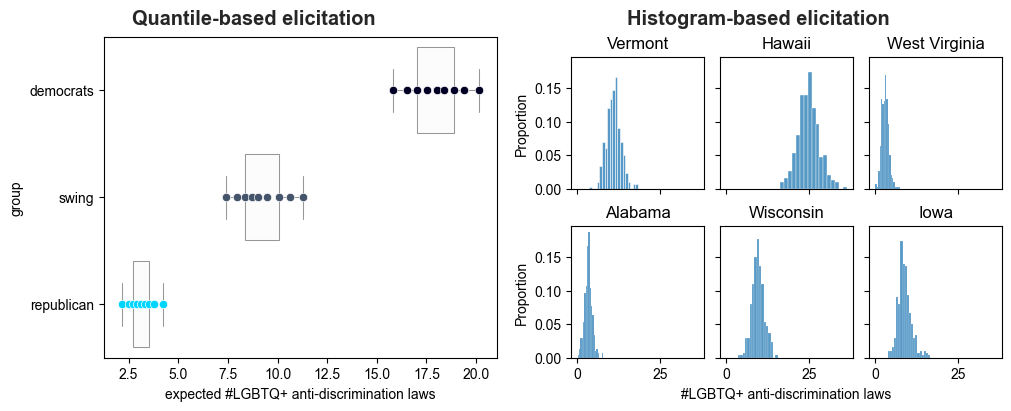

In [7]:
# number of patients who died within five years out of 𝑇 = 100 trials
# for 0, 5, 10, 15, 20, 25, 30 axillary nodes
plot_expert_pred_poisson(expert_res_list, names_states)

## Learn the prior distributions

In [8]:
res_dict = trainer(expert_res_list, user_config["B"], user_config["rep"],
                   parameters_dict, user_config["method"], GenerativeModel,
                   target_info, user_config, loss_balancing = True, save_vals = ["prior_preds"],
                   dmatrix = dmatrix, dmatrix_fct = dmatrix_fct, cmatrix = cmatrix, total_count = u_thres)

epoch_time: 1276.192ms
Epoch: 0, loss: 8.58497, lr: 0.100000
epoch_time: 277.318ms
Epoch: 60, loss: 3.09110, lr: 0.028243
epoch_time: 257.559ms
Epoch: 120, loss: 1.08937, lr: 0.007977
epoch_time: 261.705ms
Epoch: 180, loss: 0.74707, lr: 0.002253
epoch_time: 225.991ms
Epoch: 240, loss: 0.74481, lr: 0.000636
epoch_time: 219.425ms
Epoch: 300, loss: 0.74639, lr: 0.000180
epoch_time: 226.921ms
Epoch: 360, loss: 0.74623, lr: 0.000100
epoch_time: 254.224ms
Epoch: 420, loss: 0.74537, lr: 0.000100
epoch_time: 271.174ms
Epoch: 480, loss: 0.74634, lr: 0.000100
epoch_time: 246.705ms
Epoch: 540, loss: 0.74681, lr: 0.000100


## Results

### Loss function

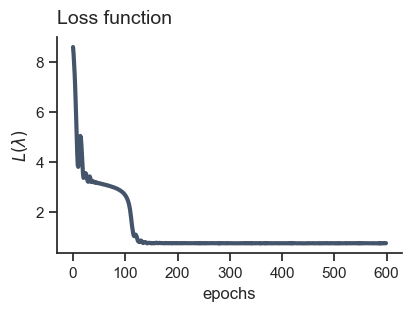

In [9]:
plot_loss(res_dict["loss_info"])

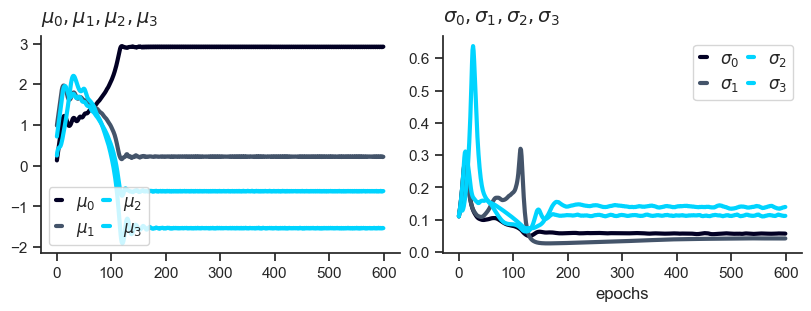

In [13]:
plot_hyp_pois(res_dict, user_config)

### Final learned hyperparameter values

In [11]:
true_vals = [j for i in zip(true_values["mu"],true_values["sigma"]) for j in i]

tab, avg_res = _print_restab(method = "hyperparameter_learning", 
                             num_vars = 8, 
                             res = res_dict["hyperparam_info"], 
                             start = 5, 
                             precision = 3, 
                             true_values = true_vals)
tab

var_name,pred mean,pred std,true,err
loc_0,2.918,0.006,2.91,0.008
scale_0,0.057,0.0,0.07,0.013
loc_1,0.223,0.007,0.23,0.007
scale_1,0.042,0.0,0.05,0.008
loc_2,-1.532,0.005,-1.51,0.022
scale_2,0.138,0.001,0.135,0.003
loc_3,-0.626,0.006,-0.61,0.016
scale_3,0.112,0.0,0.105,0.007


### Learned prior distributions

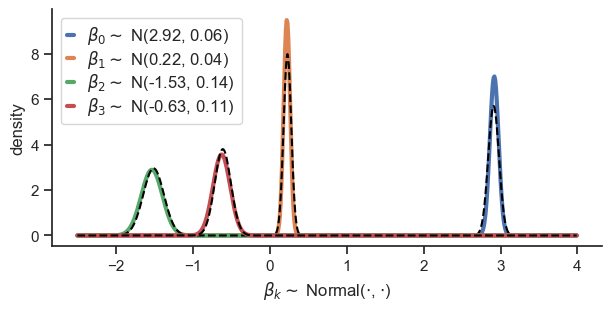

In [12]:
plot_priors(avg_res, true_vals, xrange = (-2.5, 4), loc = "upper left")